PyTorch – Brain Tumor MRI Classification Using CNN with Learning Rate Scheduling

This section is a continuation of the Brain Tumor MRI classification, with the addition of a Learning Rate (LR) Scheduler.

Learning Rate (LR) Scheduler is a tool that adjusts the learning rate during the training process. This model optimization starts fast to cover distance quickly and slows down as it approaches the destination to avoid overshooting. By adding this tool, helped stabilize your validation loss and eliminated the large "spikes" seen in the earlier training runs.

In [1]:
import torch

if torch.cuda.is_available():
    print("GPU detected!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    device = torch.device("cuda")
else:
    print("GPU not detected. Using CPU.")
    device = torch.device("cpu")


GPU detected!
Device name: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA version: 12.1


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_dataset = ImageFolder(r'C:\Users\cw_86\OneDrive\Documents\project\brain_tumor_mri_basic\Training')
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder(r'C:\Users\cw_86\OneDrive\Documents\project\brain_tumor_mri_basic\Testing')
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

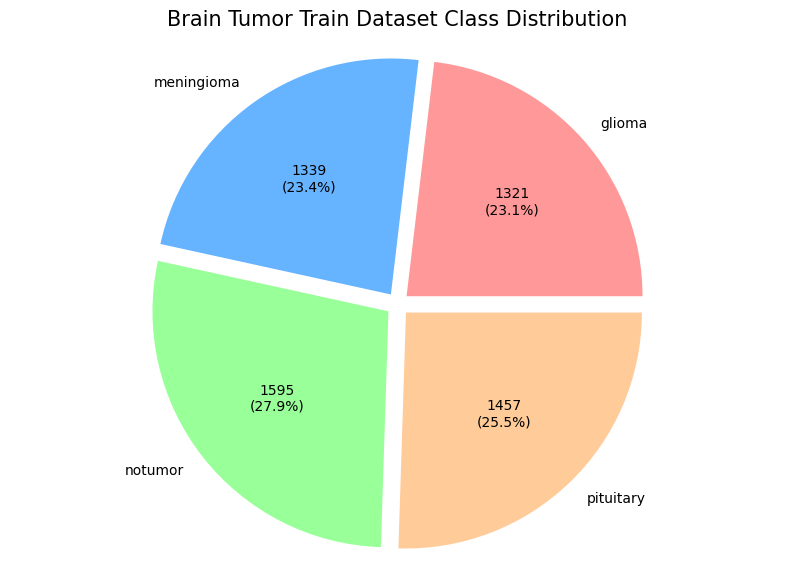

In [5]:
import matplotlib.pyplot as plt

# Access the labels directly from the ImageFolder object
targets = torch.tensor(train_dataset.targets)
# Get unique labels and their respective counts
_, counts = torch.unique(targets, return_counts=True)

# 1. Get data from the defined variables
class_names = train_dataset.classes
class_counts = counts.tolist()

# Function to display both actual count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{val}\n({pct:.1f}%)' # Displays: Count \n (Percentage%)
    return my_autopct

# 2. Visualization Settings
plt.figure(figsize=(10, 7))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# 3. Create Pie Chart
plt.pie(
    class_counts,
    labels=class_names,
    autopct=make_autopct(class_counts), # Use custom function for count and %
    colors=colors[:len(class_names)],
    explode=[0.05] * len(class_names)
)

plt.title("Brain Tumor Train Dataset Class Distribution", fontsize=15)
plt.axis('equal')
plt.show()


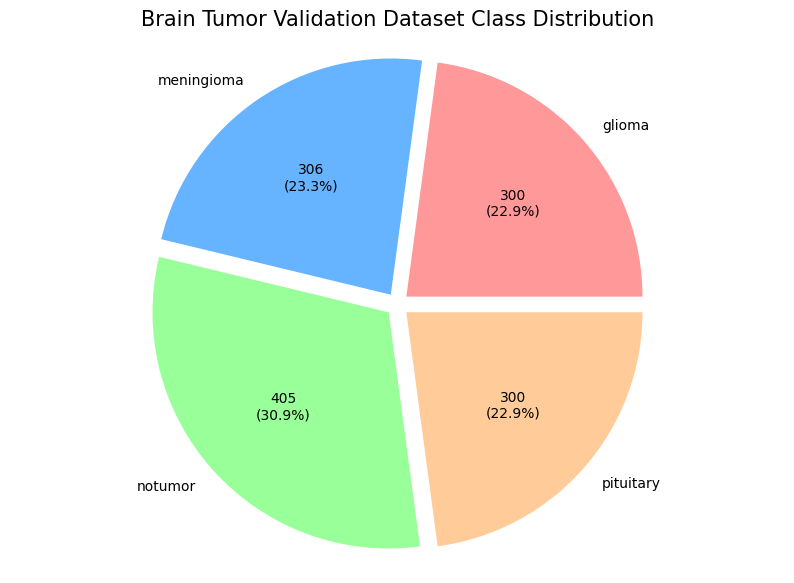

In [6]:
import torch
import matplotlib.pyplot as plt

# 1. Calculate class distribution for the validation dataset
val_targets = torch.tensor(val_dataset.targets)
val_labels, val_counts_tensor = torch.unique(val_targets, return_counts=True)

# Convert to list for plotting
val_class_names = val_dataset.classes
val_class_counts = val_counts_tensor.tolist()

# Function to display both actual count and percentage
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{val}\n({pct:.1f}%)'
    return my_autopct

# 2. Visualization Settings
plt.figure(figsize=(10, 7))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

# 3. Create Pie Chart
plt.pie(
    val_class_counts,
    labels=val_class_names,
    autopct=make_autopct(val_class_counts),
    colors=colors[:len(val_class_names)],
    explode=[0.05] * len(val_class_names)
)

plt.title("Brain Tumor Validation Dataset Class Distribution", fontsize=15)
plt.axis('equal')
plt.show()


In [7]:
from torchvision import transforms
from torch.utils.data import DataLoader

# 1. Define TRANSFORMATIONS for Training (With Augmentation)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Define TRANSFORMATIONS for Validation (NO Flips or Rotations)
# This keeps the test data consistent for reliable evaluation
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Apply specific transforms to each dataset object
# (Ensure train_dataset and val_dataset were already defined via ImageFolder)
train_dataset.transform = data_transforms
val_dataset.transform = val_transforms

# 4. Update Loaders to apply the new transforms
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

print("Transforms successfully applied to datasets and loaders.")


Transforms successfully applied to datasets and loaders.


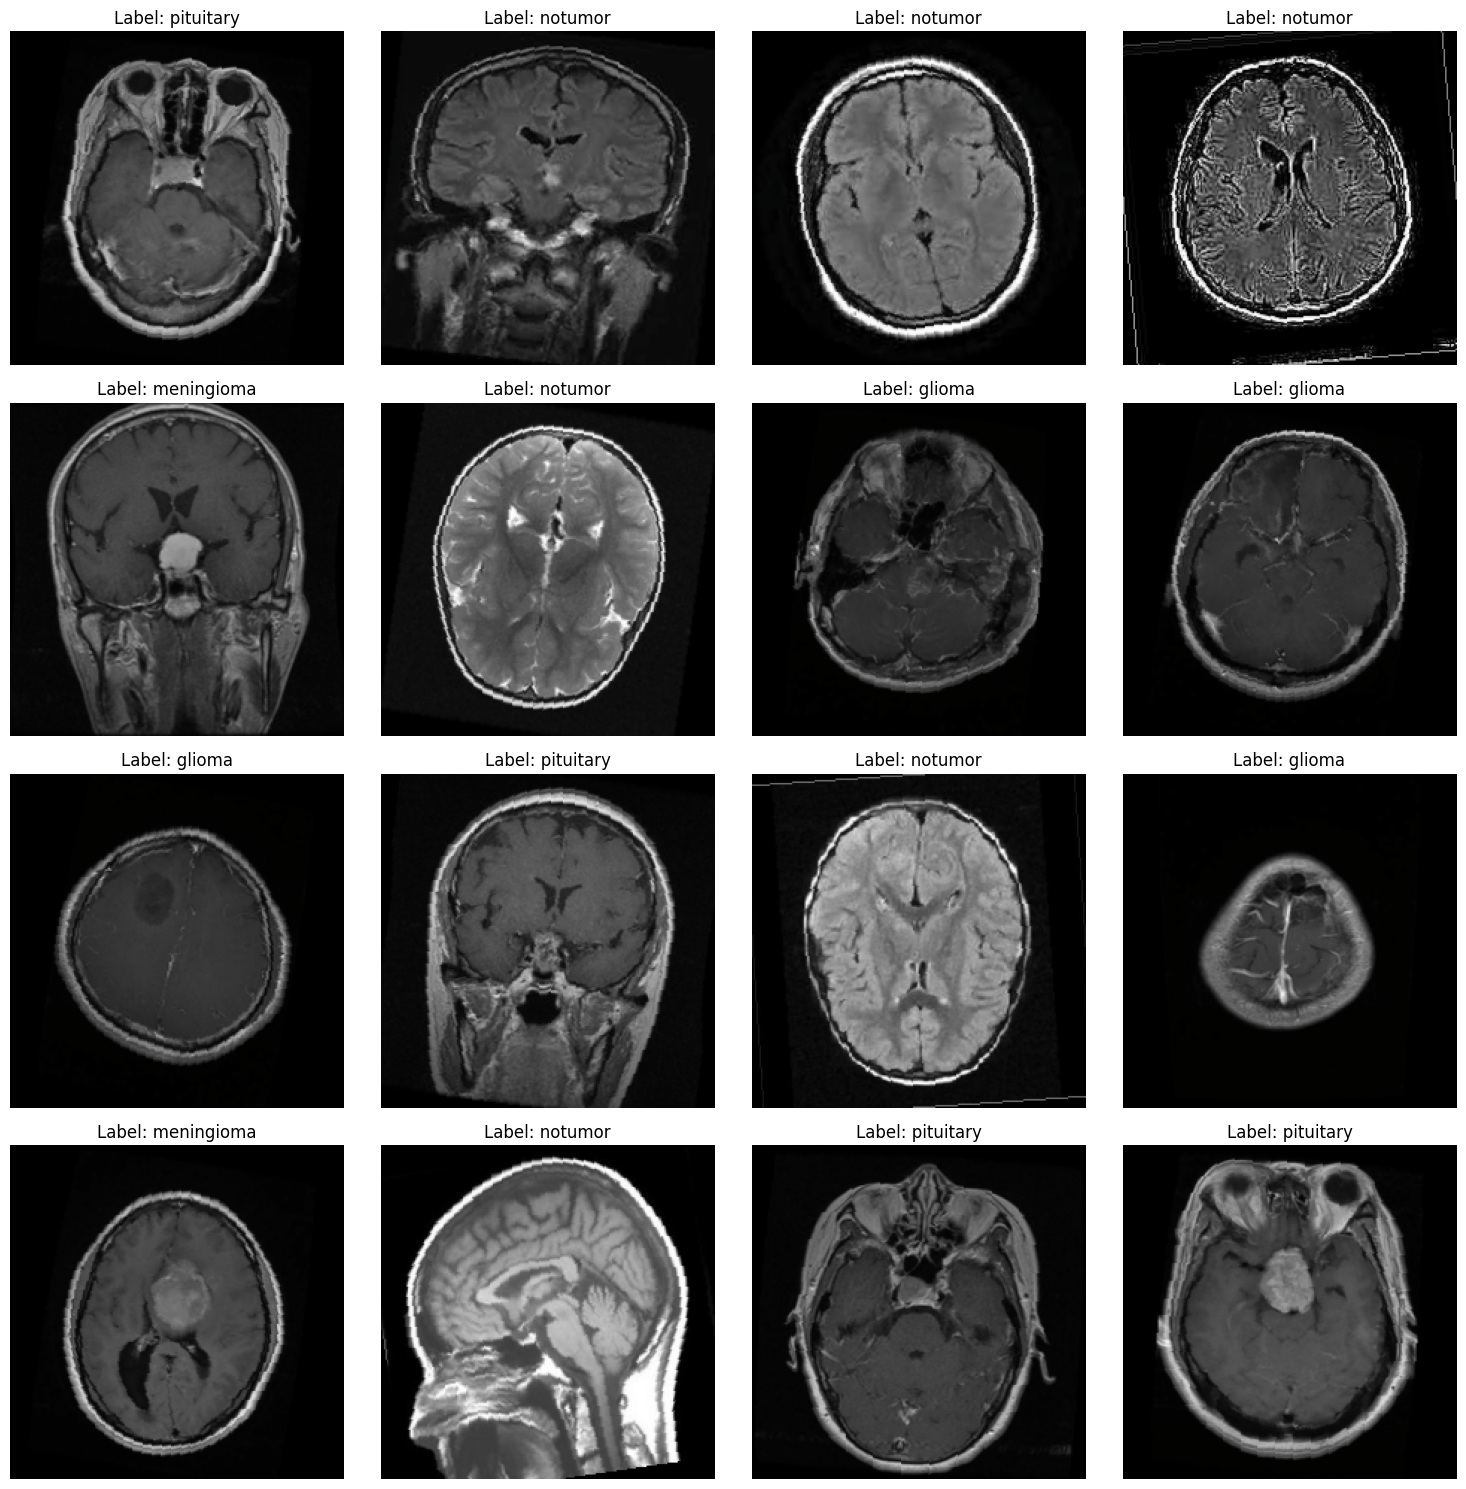

In [8]:
# Load a batch of images and labels for visualization
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert images to numpy arrays and denormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = (images.numpy().transpose((0, 2, 3, 1)) * std + mean).clip(0, 1)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))
fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import precision_score, recall_score


class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()

        # 1. Feature Extraction Path (Convolutional Layers)
        # This part detects visual patterns like edges, textures, and tumor shapes
        self.features = nn.Sequential(
            # First Layer: Input 3 channels (RGB), Output 16 filters.
            # Kernel 3x3 with padding=1 keeps the spatial dimensions same.
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), # Non-linear activation
            nn.MaxPool2d(kernel_size=2, stride=2), # Reduces size from 224x224 to 112x112

            # Second Layer: Input 16 filters, Output 32 filters.
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size from 112x112 to 56x56
        )

        # 2. Classification Path (Fully Connected Layers)
        # This part makes the final decision based on extracted features
        self.classifier = nn.Sequential(
            # Flattened input: 32 channels * 56px * 56px height/width
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            # Final output layer: mapped to the number of tumor classes (4)
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.features(x)

        # Flatten the 3D feature maps into a 1D vector for the linear layer
        # x.size(0) is the batch size
        x = x.view(x.size(0), -1)

        # Pass the vector through the classifier
        x = self.classifier(x)
        return x

# Initialize the custom CNN model for 4 classes
model = TumorClassifier(num_classes=4)

# Move the model to the detected device (GPU/CUDA or CPU)
model.to(device)

# 3. Training Components
# Use CrossEntropyLoss because it's a multi-class classification task, Added label_smoothing to help prevent overfitting
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Adam optimizer updates model weights based on calculated gradients
# Learning rate is set to 0.001 for a balanced training speed
# Added weight_decay to help with the "spikes" in the graph
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define the Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)



# Initialize history logs
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

num_epochs = 20
best_val_accuracy = 0.0
num_classes = 4 # Based on the dataset (Glioma, Meningioma, Pituitary, No Tumor)

# Helper function to calculate P/R/Acc from accumulated data
def calculate_metrics(all_labels, all_preds):
    # Sklearn handles the complex multi-class averaging easily
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    accuracy = (all_preds == all_labels).mean()
    return precision, recall, accuracy

for epoch in range(num_epochs):
    # ================= TRAINING PHASE =================
    model.train()
    running_train_loss = 0.0
    all_train_labels, all_train_preds = [], []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and labels for epoch-end calculation
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())
    
    # Calculate Epoch Training Metrics
    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_precision, epoch_train_recall, epoch_train_acc = calculate_metrics(
        all_train_labels, all_train_preds
    )
    
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    train_precisions.append(epoch_train_precision)
    train_recalls.append(epoch_train_recall)

    # ================= VALIDATION PHASE =================
    model.eval()
    running_val_loss = 0.0
    all_val_labels, all_val_preds = [], []
    
    with torch.no_grad(): # Critical: Disables gradient to save memory
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Accumulate loss
            running_val_loss += loss.item() * inputs.size(0)

            # Store predictions and labels for epoch-end calculation
            _, predicted = torch.max(outputs, 1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())
            
    # Calculate Epoch Validation Metrics
    epoch_val_loss = running_val_loss / len(val_dataset)
    scheduler.step(epoch_val_loss)
    epoch_val_precision, epoch_val_recall, epoch_val_acc = calculate_metrics(
        all_val_labels, all_val_preds
    )
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    val_precisions.append(epoch_val_precision)
    val_recalls.append(epoch_val_recall)
    
    # Printing logs
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}] | Current LR: {current_lr:.6f}')
    print(f'Train Acc: {epoch_train_acc:.2%} | Val Acc: {epoch_val_acc:.2%}')
    print(f'Train Prec: {epoch_train_precision:.2f} | Val Prec: {epoch_val_precision:.2f}')
    print(f'Train Rec:  {epoch_train_recall:.2f} | Val Rec:  {epoch_val_recall:.2f}')
    print('-' * 40)
    
    # Save the best model based on REAL validation accuracy
    if epoch_val_acc > best_val_accuracy:
        best_val_accuracy = epoch_val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"[*] New Best Model Saved (Acc: {best_val_accuracy:.2%})")

Epoch [1/20] | Current LR: 0.001000
Train Acc: 77.56% | Val Acc: 85.35%
Train Prec: 0.77 | Val Prec: 0.85
Train Rec:  0.77 | Val Rec:  0.85
----------------------------------------
[*] New Best Model Saved (Acc: 85.35%)
Epoch [2/20] | Current LR: 0.001000
Train Acc: 88.55% | Val Acc: 86.12%
Train Prec: 0.88 | Val Prec: 0.86
Train Rec:  0.88 | Val Rec:  0.85
----------------------------------------
[*] New Best Model Saved (Acc: 86.12%)
Epoch [3/20] | Current LR: 0.001000
Train Acc: 91.61% | Val Acc: 92.45%
Train Prec: 0.91 | Val Prec: 0.93
Train Rec:  0.91 | Val Rec:  0.92
----------------------------------------
[*] New Best Model Saved (Acc: 92.45%)
Epoch [4/20] | Current LR: 0.001000
Train Acc: 94.01% | Val Acc: 93.97%
Train Prec: 0.94 | Val Prec: 0.94
Train Rec:  0.94 | Val Rec:  0.94
----------------------------------------
[*] New Best Model Saved (Acc: 93.97%)
Epoch [5/20] | Current LR: 0.001000
Train Acc: 96.17% | Val Acc: 94.66%
Train Prec: 0.96 | Val Prec: 0.95
Train Rec:  0.

In [10]:
# 1. Initialize the CUSTOM model (not ResNet)
model = TumorClassifier(num_classes=4)

# 2. Load the weights specifically for this architecture
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

# 3. Move to device and set to evaluation mode
model.to(device)
model.eval()

print("\n" + "="*35)
print("       MODEL LOADED SUCCESSFULLY       ")
print("="*35)

# --- RUN FINAL EVALUATION ---
final_correct = 0
final_total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        final_total += labels.size(0)
        final_correct += (predicted == labels).sum().item()

final_accuracy = final_correct / final_total
print(f'Final Accuracy on Validation Set: {final_accuracy:.2%}')



       MODEL LOADED SUCCESSFULLY       
Final Accuracy on Validation Set: 98.63%


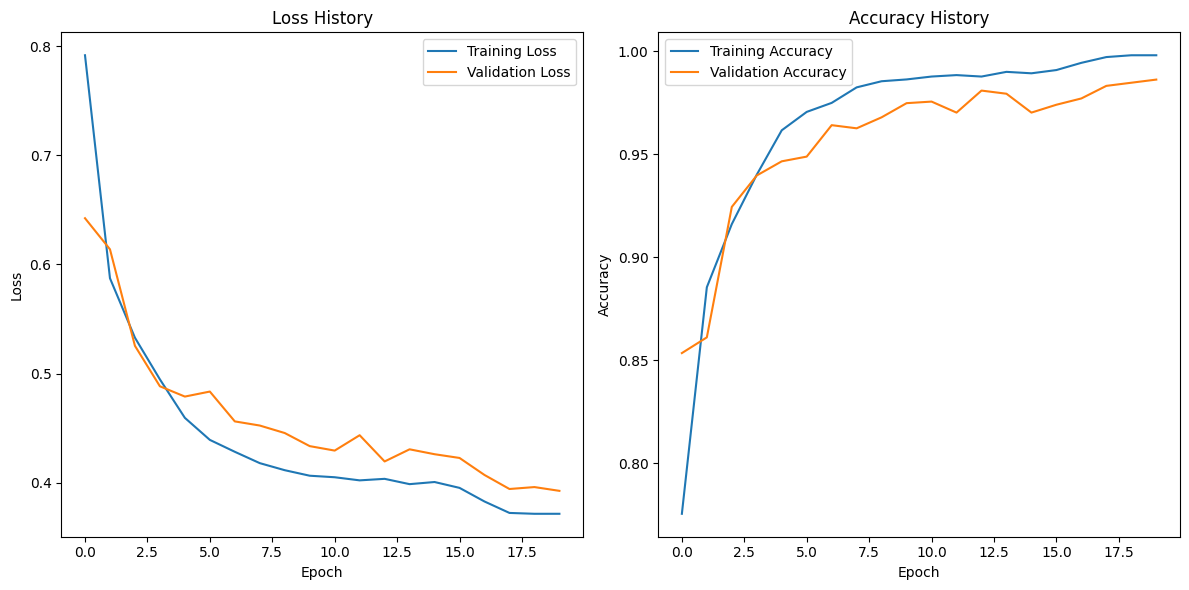

In [11]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

In this graph, after comparing it with the graph before the Learning Rate (LR) Scheduling was carried out, it can be seen that the validation curves are significantly smoother, showing that the Learning Rate Scheduler and Weight Decay are successfully keeping the training under control.

The training and validation lines stay much closer together throughout the entire 20 epochs. This means the model is generalizing well and will likely perform more accurately on new, unseen MRI scans.

Because of Label Smoothing, the model is being penalized for being "too confident." This prevents the loss from dropping to near-zero (which usually signals memorization) and instead forces the model to maintain a realistic margin of error, making it much more robust. But, the validation accuracy was still slightly "noisy" and trending upward. This can be overcome by adding more epochs.

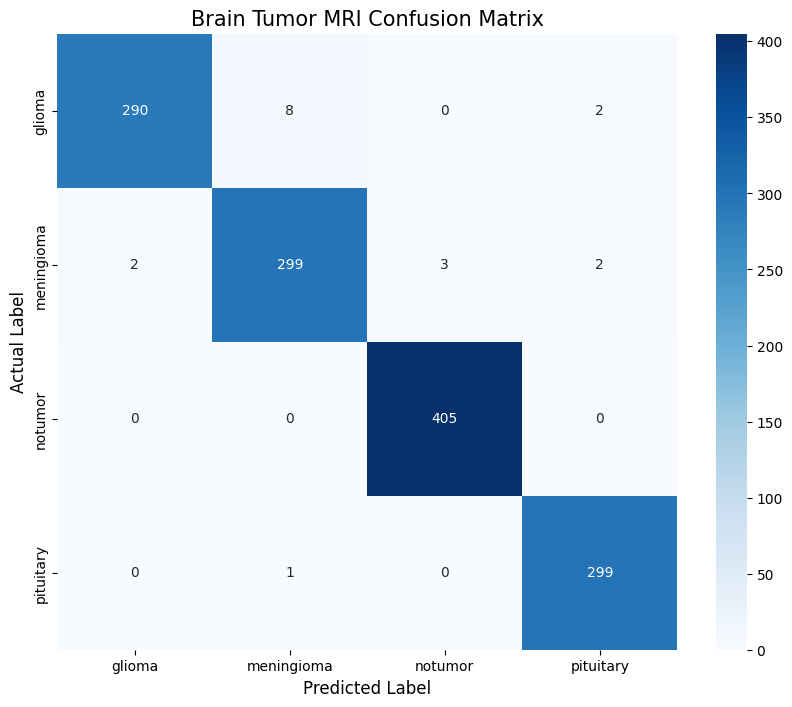


Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.97      0.98      0.97       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch

# 1. Gather all predictions and true labels
all_preds = []
all_true_labels = []

model.eval() # Ensure model is in evaluation mode
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        # Get the index of the highest probability
        _, predicted = torch.max(outputs, 1)
        
        # Move data to CPU and convert to numpy lists
        all_preds.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.numpy())

# 2. Generate the Confusion Matrix
# val_dataset.classes contains your labels like ['Glioma', 'Meningioma', etc.]
cm = confusion_matrix(all_true_labels, all_preds)

# 3. Visualize using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True,               # Show the numbers in each cell
    fmt='d',                  # Format as integers
    cmap='Blues',             # High contrast color scheme
    xticklabels=val_dataset.classes, 
    yticklabels=val_dataset.classes
)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.title('Brain Tumor MRI Confusion Matrix', fontsize=15)
plt.show()

# 4. Print Detailed Metrics (Precision, Recall, F1-Score)
print("\nDetailed Classification Report:")
print(classification_report(all_true_labels, all_preds, target_names=val_dataset.classes))


After applying a learning rate (LR) scheduler over an additional 20 epochs, it can be seen that there is a refinements in the model's ability to distinguish between visually similar classes. Precise learning rate management helps stabilize the training process, leading to better generalization and potentially reducing the misclassifications seen in your initial confusion matrix.

The Glioma and Meningioma often have overlapping features in MRI scans. A decaying learning rate allows the model to make smaller, more precise weight updates, which can help it capture the subtle edge and texture differences that distinguish them. By lowering the learning rate as training progresses, the model avoids "jumping over" the optimal loss minimum. This often translates to higher Precision (fewer false positives) for the classes that previously had the most confusion.

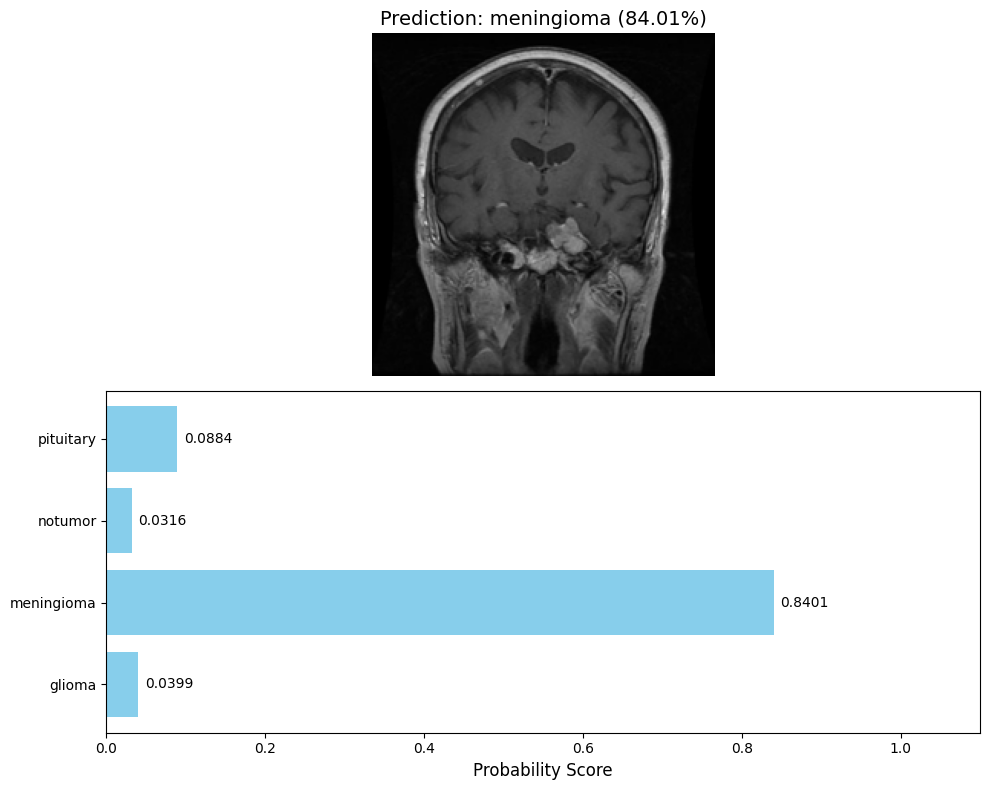

In [13]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def predict_pytorch(img_path, model, class_names):
    """
    Predicts the brain tumor class for a given MRI image using a trained PyTorch model.
    """
    # 1. Load and Preprocess the Image
    # Convert to RGB to ensure 3 channels (matches training data)
    img = Image.open(img_path).convert('RGB')
    
    # Apply identical transformations used during validation
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # Normalize using ImageNet standards
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Transform image and add a batch dimension (1, 3, 224, 224)
    input_tensor = preprocess(img).unsqueeze(0) 
    input_tensor = input_tensor.to(device)

    # 2. Model Inference
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor)
        # Convert raw output (logits) to probabilities using Softmax
        probabilities = F.softmax(output, dim=1)[0]
    
    # Move to CPU for plotting
    probs = probabilities.cpu().numpy()
    predicted_class_idx = np.argmax(probs)
    predicted_label = class_names[predicted_class_idx]
    
    # 3. Visualization
    plt.figure(figsize=(10, 8))
    
    # Subplot 1: Original Image
    plt.subplot(2, 1, 1)
    plt.imshow(img.resize((224, 224)))
    plt.title(f"Prediction: {predicted_label} ({probs[predicted_class_idx]:.2%})", fontsize=14)
    plt.axis('off')
    
    # Subplot 2: Probability Bar Chart
    plt.subplot(2, 1, 2)
    bars = plt.barh(class_names, probs, color='skyblue')
    plt.xlabel('Probability Score', fontsize=12)
    plt.xlim(0, 1.1) # Maximum scale of 100% + padding
    
    # Add numerical labels to the end of each bar
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.4f', padding=5)
    
    plt.tight_layout()
    plt.show()

# --- Execution ---
image_path = r'C:\Users\cw_86\OneDrive\Documents\project\brain_tumor_mri_basic\Testing\meningioma\Te-me_0162.jpg'

predict_pytorch(image_path, model, train_dataset.classes)


This shows refinement in the model's ability to distinguish between complex classes. A scheduler allows the model to settle into a more optimal local minimum by reducing the weight updates as it approaches convergence.

Reducing the learning rate has been empirically shown to improve the learning of "complex patterns" while suppressing the memorization of noise, leading to better performance on validation/test sets.

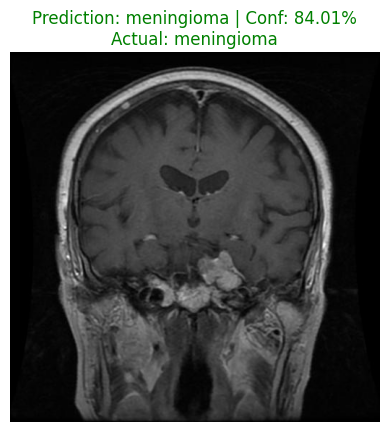


Conclusion: Image predicted as meningioma with 84.01% confidence. The actual label is meningioma.


In [14]:
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os

def predict_single_image(image_path, model, device, class_names, actual_label=None):
    """
    Loads a single image, processes it, displays it, and generates a tumor class prediction,
    along with the actual label if provided.
    """
    # 1. Define Transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # 2. Load and Apply Transformation to Image
    image_original = Image.open(image_path).convert('RGB')
    image_processed = transform(image_original)
    image_processed = image_processed.unsqueeze(0).to(device)

    # 3. Perform Inference
    model.eval()
    with torch.no_grad():
        outputs = model(image_processed)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted_idx = torch.max(outputs, 1)
        
    # 4. Interpret Results
    predicted_idx = predicted_idx.item()
    confidence = probabilities[0, predicted_idx].item()
    predicted_class_name = class_names[predicted_idx]

    # 5. DISPLAY IMAGE AND RESULTS
    plt.imshow(np.array(image_original))
    
    title_text = f"Prediction: {predicted_class_name} | Conf: {confidence:.2%}"
    if actual_label:
        title_text += f"\nActual: {actual_label}"
        # Set title color based on whether the prediction is correct
        if predicted_class_name == actual_label:
            plt.title(title_text, color='green')
        else:
            plt.title(title_text, color='red')
    else:
        plt.title(title_text)
        
    plt.axis('off')
    plt.show()

    return predicted_class_name, confidence

# --- Example Usage ---

class_labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary'] 
# Ensure 'model' and 'device' are already loaded from previous code

# Define the test image PATH
test_image_path = r'C:\Users\cw_86\OneDrive\Documents\project\brain_tumor_mri_basic\Testing\meningioma\Te-me_0162.jpg'

# Automatically extract the actual label from the folder name (efficient method)
actual_label_name = os.path.basename(os.path.dirname(test_image_path))

# Call the function including the actual label
predicted_label, confidence_score = predict_single_image(
    test_image_path, 
    model, 
    device, 
    class_labels, 
    actual_label=actual_label_name # <--- Input actual label here
)

print(f"\nConclusion: Image predicted as {predicted_label} with {confidence_score:.2%} confidence. The actual label is {actual_label_name}.")


== 30 Epochs ==

This section continues the Brain Tumor MRI classification by adding a Learning Rate (LR) Scheduler and increasing the training epochs to 30.

Increasing from 20 to 30 epochs allowed the model to move from a state of "learning the basics" to "mastering the details". By extending to 30 epochs, it gave the Learning Rate Scheduler time to trigger.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import precision_score, recall_score


class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()

        # 1. Feature Extraction Path (Convolutional Layers)
        # This part detects visual patterns like edges, textures, and tumor shapes
        self.features = nn.Sequential(
            # First Layer: Input 3 channels (RGB), Output 16 filters.
            # Kernel 3x3 with padding=1 keeps the spatial dimensions same.
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True), # Non-linear activation
            nn.MaxPool2d(kernel_size=2, stride=2), # Reduces size from 224x224 to 112x112

            # Second Layer: Input 16 filters, Output 32 filters.
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces size from 112x112 to 56x56
        )

        # 2. Classification Path (Fully Connected Layers)
        # This part makes the final decision based on extracted features
        self.classifier = nn.Sequential(
            # Flattened input: 32 channels * 56px * 56px height/width
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            # Final output layer: mapped to the number of tumor classes (4)
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Pass input through convolutional layers
        x = self.features(x)

        # Flatten the 3D feature maps into a 1D vector for the linear layer
        # x.size(0) is the batch size
        x = x.view(x.size(0), -1)

        # Pass the vector through the classifier
        x = self.classifier(x)
        return x

# Initialize the custom CNN model for 4 classes
model = TumorClassifier(num_classes=4)

# Move the model to the detected device (GPU/CUDA or CPU)
model.to(device)

# 3. Training Components
# Use CrossEntropyLoss because it's a multi-class classification task, Added label_smoothing to help prevent overfitting
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Adam optimizer updates model weights based on calculated gradients
# Learning rate is set to 0.001 for a balanced training speed
# Added weight_decay to help with the "spikes" in the graph
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Define the Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)



# Initialize history logs
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []

num_epochs = 30
best_val_accuracy = 0.0
num_classes = 4 # Based on the dataset (Glioma, Meningioma, Pituitary, No Tumor)

# Helper function to calculate P/R/Acc from accumulated data
def calculate_metrics(all_labels, all_preds):
    # Sklearn handles the complex multi-class averaging easily
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    accuracy = (all_preds == all_labels).mean()
    return precision, recall, accuracy

for epoch in range(num_epochs):
    # ================= TRAINING PHASE =================
    model.train()
    running_train_loss = 0.0
    all_train_labels, all_train_preds = [], []
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)

        # Store predictions and labels for epoch-end calculation
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())
    
    # Calculate Epoch Training Metrics
    epoch_train_loss = running_train_loss / len(train_dataset)
    epoch_train_precision, epoch_train_recall, epoch_train_acc = calculate_metrics(
        all_train_labels, all_train_preds
    )
    
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    train_precisions.append(epoch_train_precision)
    train_recalls.append(epoch_train_recall)

    # ================= VALIDATION PHASE =================
    model.eval()
    running_val_loss = 0.0
    all_val_labels, all_val_preds = [], []
    
    with torch.no_grad(): # Critical: Disables gradient to save memory
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Accumulate loss
            running_val_loss += loss.item() * inputs.size(0)

            # Store predictions and labels for epoch-end calculation
            _, predicted = torch.max(outputs, 1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())
            
    # Calculate Epoch Validation Metrics
    epoch_val_loss = running_val_loss / len(val_dataset)
    scheduler.step(epoch_val_loss)
    epoch_val_precision, epoch_val_recall, epoch_val_acc = calculate_metrics(
        all_val_labels, all_val_preds
    )
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    val_precisions.append(epoch_val_precision)
    val_recalls.append(epoch_val_recall)
    
    # Printing logs
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}] | Current LR: {current_lr:.6f}')
    print(f'Train Acc: {epoch_train_acc:.2%} | Val Acc: {epoch_val_acc:.2%}')
    print(f'Train Prec: {epoch_train_precision:.2f} | Val Prec: {epoch_val_precision:.2f}')
    print(f'Train Rec:  {epoch_train_recall:.2f} | Val Rec:  {epoch_val_recall:.2f}')
    print('-' * 40)
    
    # Save the best model based on REAL validation accuracy
    if epoch_val_acc > best_val_accuracy:
        best_val_accuracy = epoch_val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"[*] New Best Model Saved (Acc: {best_val_accuracy:.2%})")

Epoch [1/30] | Current LR: 0.001000
Train Acc: 73.02% | Val Acc: 80.47%
Train Prec: 0.72 | Val Prec: 0.80
Train Rec:  0.72 | Val Rec:  0.79
----------------------------------------
[*] New Best Model Saved (Acc: 80.47%)
Epoch [2/30] | Current LR: 0.001000
Train Acc: 86.01% | Val Acc: 86.12%
Train Prec: 0.85 | Val Prec: 0.85
Train Rec:  0.85 | Val Rec:  0.85
----------------------------------------
[*] New Best Model Saved (Acc: 86.12%)
Epoch [3/30] | Current LR: 0.001000
Train Acc: 90.14% | Val Acc: 87.03%
Train Prec: 0.90 | Val Prec: 0.87
Train Rec:  0.90 | Val Rec:  0.86
----------------------------------------
[*] New Best Model Saved (Acc: 87.03%)
Epoch [4/30] | Current LR: 0.001000
Train Acc: 93.21% | Val Acc: 89.63%
Train Prec: 0.93 | Val Prec: 0.90
Train Rec:  0.93 | Val Rec:  0.89
----------------------------------------
[*] New Best Model Saved (Acc: 89.63%)
Epoch [5/30] | Current LR: 0.001000
Train Acc: 94.75% | Val Acc: 93.75%
Train Prec: 0.95 | Val Prec: 0.94
Train Rec:  0.

In [16]:
# 1. Initialize the CUSTOM model (not ResNet)
model = TumorClassifier(num_classes=4)

# 2. Load the weights specifically for this architecture
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

# 3. Move to device and set to evaluation mode
model.to(device)
model.eval()

print("\n" + "="*35)
print("       MODEL LOADED SUCCESSFULLY       ")
print("="*35)

# --- RUN FINAL EVALUATION ---
final_correct = 0
final_total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        final_total += labels.size(0)
        final_correct += (predicted == labels).sum().item()

final_accuracy = final_correct / final_total
print(f'Final Accuracy on Validation Set: {final_accuracy:.2%}')



       MODEL LOADED SUCCESSFULLY       
Final Accuracy on Validation Set: 98.86%


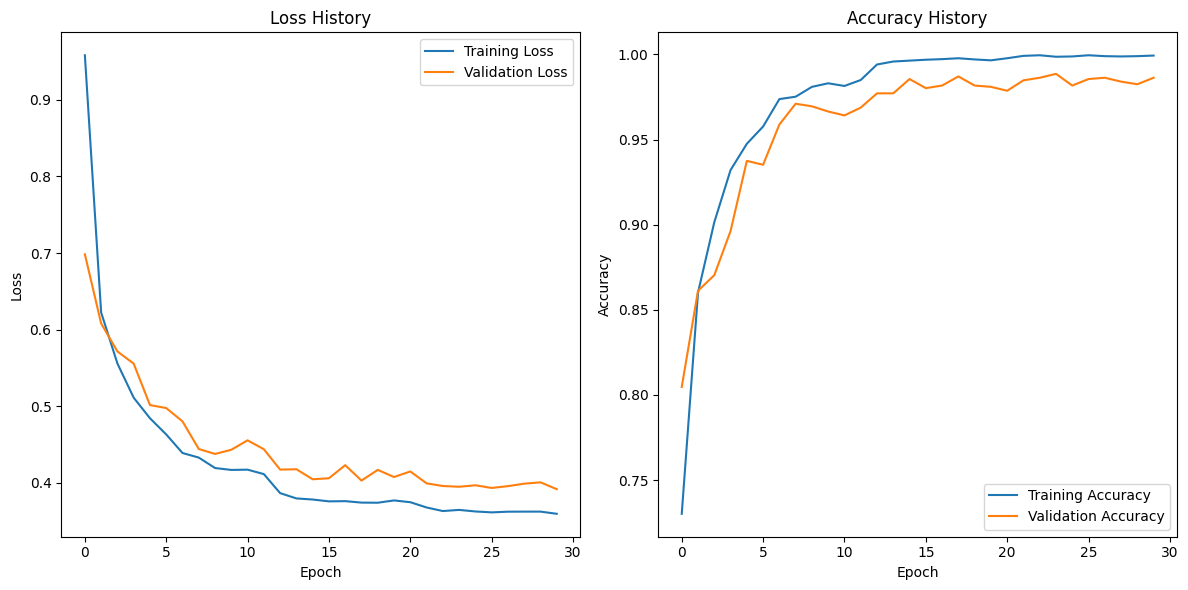

In [17]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

The model took smaller steps, allowing the training accuracy to reach near 100% and the validation accuracy to settle at a stable 98.5% without the pronounced fluctuations observed in earlier training.

This "plateau" is the signal that the model has reached its peak performance and that further training would likely lead to overfitting.

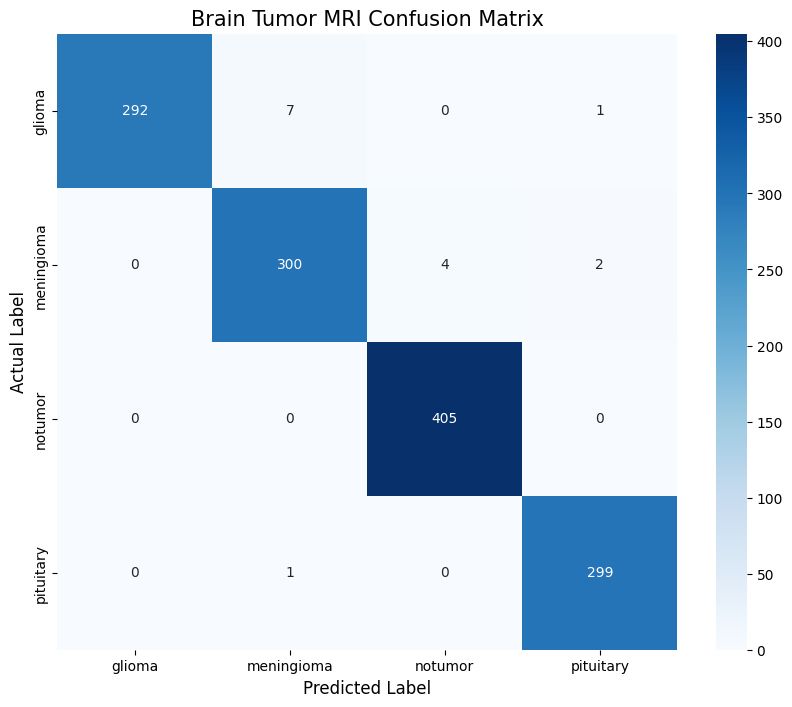


Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.97      0.99       300
  meningioma       0.97      0.98      0.98       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch

# 1. Gather all predictions and true labels
all_preds = []
all_true_labels = []

model.eval() # Ensure model is in evaluation mode
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        # Get the index of the highest probability
        _, predicted = torch.max(outputs, 1)
        
        # Move data to CPU and convert to numpy lists
        all_preds.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.numpy())

# 2. Generate the Confusion Matrix
# val_dataset.classes contains your labels like ['Glioma', 'Meningioma', etc.]
cm = confusion_matrix(all_true_labels, all_preds)

# 3. Visualize using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True,               # Show the numbers in each cell
    fmt='d',                  # Format as integers
    cmap='Blues',             # High contrast color scheme
    xticklabels=val_dataset.classes, 
    yticklabels=val_dataset.classes
)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.title('Brain Tumor MRI Confusion Matrix', fontsize=15)
plt.show()

# 4. Print Detailed Metrics (Precision, Recall, F1-Score)
print("\nDetailed Classification Report:")
print(classification_report(all_true_labels, all_preds, target_names=val_dataset.classes))


The model correctly identified 292 gliomas, up from 290 in the 20-epoch version. More importantly, the confusion with meningioma dropped from 8 down to 7.

The model reached 300 correct meningioma predictions, an improvement over the 299 from the previous run.

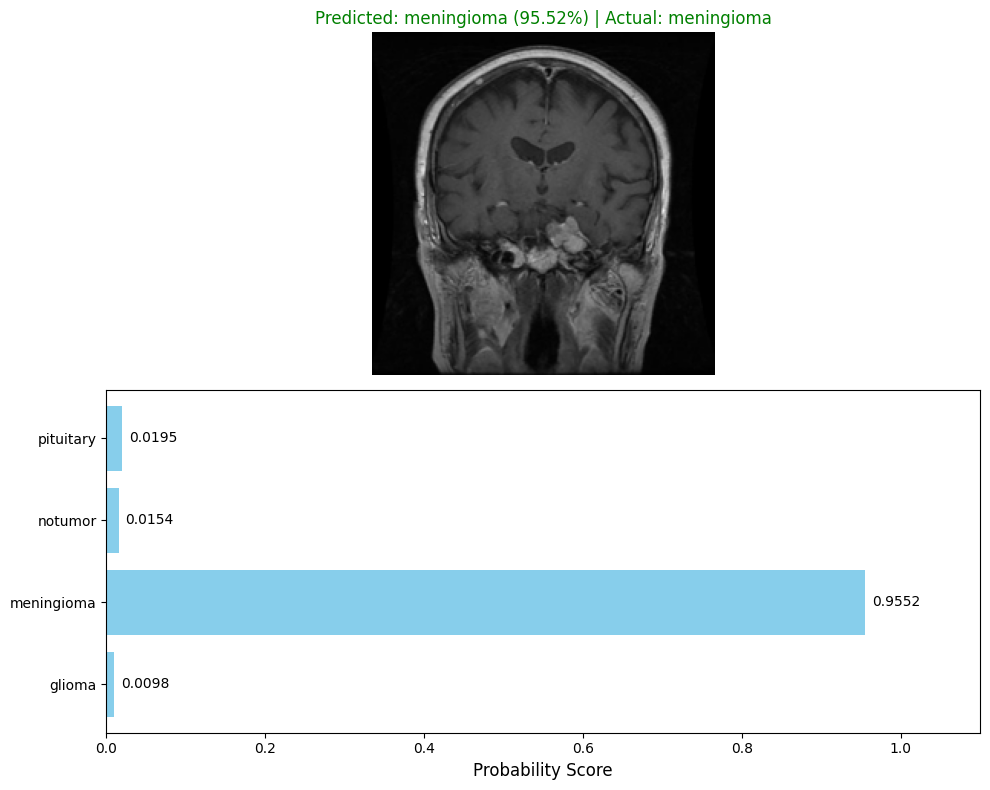


Conclusion: Image predicted as meningioma with 95.52% confidence. The actual label is meningioma.


In [24]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def predict_pytorch(img_path, model, class_names):
    """
    Predicts the brain tumor class for a given MRI image using a trained PyTorch model.
    """
    # 1. Load and Preprocess the Image
    # Automatically extract the actual label from the folder name (efficient method)
    actual_label_name = os.path.basename(os.path.dirname(test_image_path))

    # Convert to RGB to ensure 3 channels (matches training data)
    img = Image.open(img_path).convert('RGB')
    
    # Apply identical transformations used during validation
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # Normalize using ImageNet standards
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Transform image and add a batch dimension (1, 3, 224, 224)
    input_tensor = preprocess(img).unsqueeze(0) 
    input_tensor = input_tensor.to(device)

    # 2. Model Inference
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor)
        # Convert raw output (logits) to probabilities using Softmax
        probabilities = F.softmax(output, dim=1)[0]
    
    # Move to CPU for plotting
    probs = probabilities.cpu().numpy()
    predicted_class_idx = np.argmax(probs)
    predicted_label = class_names[predicted_class_idx]
    
    # 3. Visualization
    plt.figure(figsize=(10, 8))
    
    # Subplot 1: Original Image
    plt.subplot(2, 1, 1)
    plt.imshow(img.resize((224, 224)))
    plt.title(f"Predicted: {predicted_label} ({probs[predicted_class_idx]:.2%}) | Actual: {actual_label_name}", 
              fontsize=12, color='green' if actual_label_name == predicted_label else 'red')
    plt.axis('off')
    plt.axis('off')
    
    # Subplot 2: Probability Bar Chart
    plt.subplot(2, 1, 2)
    bars = plt.barh(class_names, probs, color='skyblue')
    plt.xlabel('Probability Score', fontsize=12)
    plt.xlim(0, 1.1) # Maximum scale of 100% + padding
    
    # Add numerical labels to the end of each bar
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.4f', padding=5)
    
    plt.tight_layout()
    plt.show()

# --- Execution ---
image_path = r'C:\Users\cw_86\OneDrive\Documents\project\brain_tumor_mri_basic\Testing\meningioma\Te-me_0162.jpg'

predict_pytorch(image_path, model, train_dataset.classes)
print(f"\nConclusion: Image predicted as {predicted_label} with {confidence_score:.2%} confidence. The actual label is {actual_label_name}.")
